## Assignmen Week 4

### Using Stable Diffusion API (Stability IO) to generate Image from text prompt and then Edit the same image

Stability AI provides acees to their `Stable Diffusion` Gen AI models allowing users to programatically geneate via API calls. The below steps demonsrates the process to generate image using natural language prompt in `python` language imlementatation. 

In [4]:
import requests
import base64
import os
import json

In [5]:
# get api key from file
with open("../../apikeys/stabilityio-keys.json", "r") as key_file:
    api_key = json.load(key_file)["api_secret_key"]
os.environ["STABILITY_API_KEY"] = api_key

In [6]:
user_prompt = input("Enter your prompt: ")

Enter your prompt:  a whale jumping out of water in an ocean during sunset


In [9]:
# Set the api key and model version
engine_id = "stable-diffusion-v1-6"
api_host = os.getenv('API_HOST', 'https://api.stability.ai')
api_key = os.getenv("STABILITY_API_KEY")

if api_key is None:
    raise Exception("Missing Stability API key.")

# perform api call to generate image
response = requests.post(
    f"{api_host}/v1/generation/{engine_id}/text-to-image",
    headers={
        "Content-Type": "application/json",
        "Accept": "application/json",
        "Authorization": f"Bearer {api_key}"
    },
    json={
        "text_prompts": [
            {
                "text": user_prompt
            }
        ],
        "cfg_scale": 10,
        "height": 1024,
        "width": 1024,
        "samples": 1, #generate only one sample image
        "steps": 50,
    },
)

if response.status_code != 200:
    raise Exception("Non-200 response: " + str(response.text))

# retrieve the json object of response
data = response.json()

Note. `cfg_scale` parameter is used to define how strictly the diffusion process will adhere to the prompt. We can set it to a higher value to generate an image strictly matching the prompt but in that case there are high chances of loss of creativity and deviation from reality. 

In [24]:
# create directory to store images if not exist
image_dir = os.path.join(os.path.curdir, "stabilityio/imgages/")
if os.path.exists(image_dir):
    pass
else:
    os.makedirs(image_dir)

In [26]:
# store images in directory received from api call
for i, image in enumerate(data["artifacts"]):
    with open(os.path.join(image_dir,f"v1_txt2img_{i}.png"), "wb") as f:
        print("image filename: ",os.path.join(image_dir,f"v1_txt2img_{i}.png"))
        f.write(base64.b64decode(image["base64"]))

image filename:  ./stabilityio/imgages/v1_txt2img_0.png


#### Generated Image

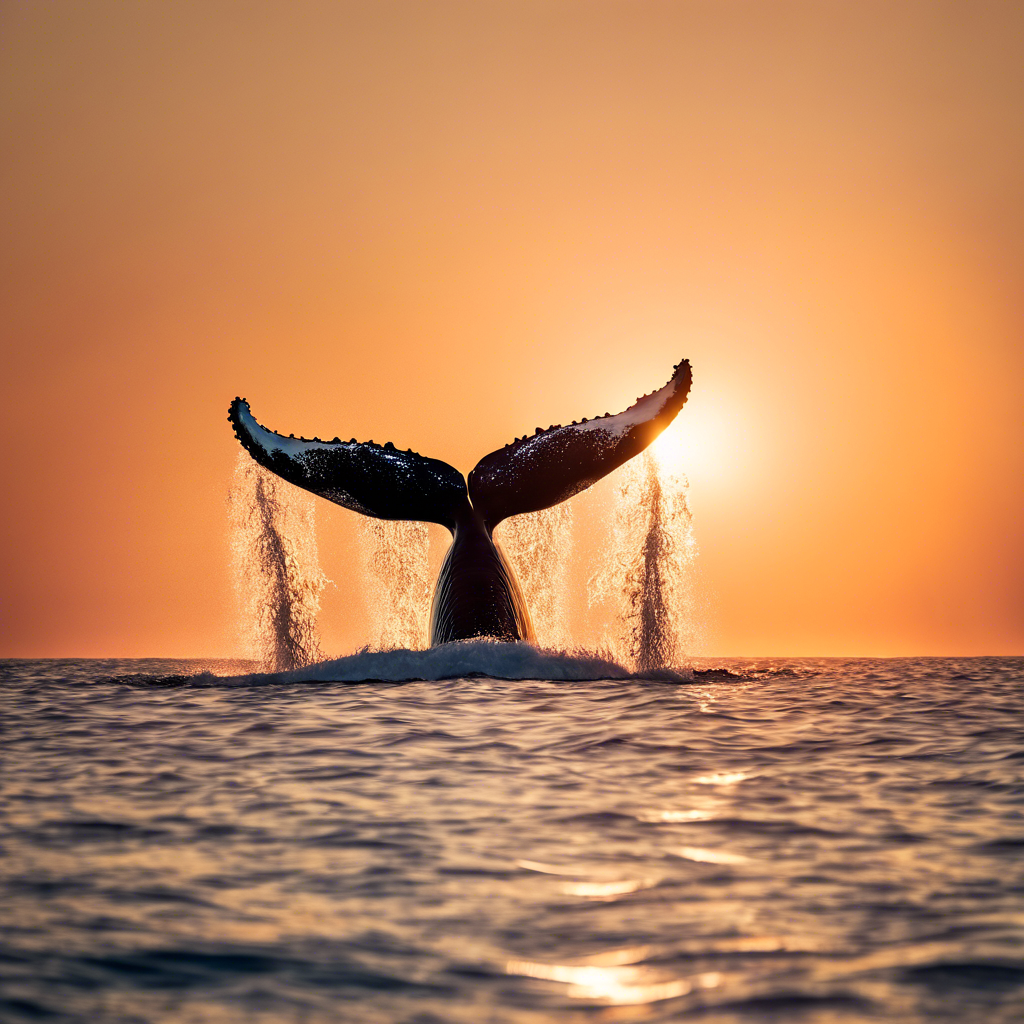

We have used Stable Diffusion version `SD v1.6` vision model for the above image generation. The generated image contains the details mentioned in the prompt. It clearly shows a whale's body part jumping out of water with sunset in the background. It is impressive to notice the high quaity and resolution of the generated image, particulary the focus on the subject and bluriness of blackground just like a realistic image captured by an exprienced photographer. 

One important point is that even though the prompt mentioned `a whale jumping out of water`, the image `only shows the tail part out of water`. This might be because that it is more common to see images of whales with only tail out of water than the full body of the whale. Hence, the model might have got traind with more whale images having only tail out of water than images with their full body. Another way we could have got image of a whale with full body jumping out of water by `explicitly instructing the vision model` to generate such images.

Stability IO provides other capabilities of vision model via API for editing images. In the below steps we have used `editing` feature to replace the `whale` in the above generated image with `dolphins`

In [27]:
# editing API call

response = requests.post(
    f"https://api.stability.ai/v2beta/stable-image/edit/search-and-replace",
    headers={
        "authorization": f"Bearer {api_key}",
        "accept": "image/*"
    },
    files={
        "image": open("./stabilityio/imgages/v1_txt2img_0.png", "rb") #image to edit
    },
    data={
        "prompt": "a pod of dolphins jumping out of water in an ocean during sunset",
        "search_prompt": "whale",
        "output_format": "jpeg",
    },
)


In [30]:
# store image content from api response in directory
if response.status_code == 200:
    with open(os.path.join(image_dir,f"replaced_img.jpeg"), "wb") as file:
        file.write(response.content)
else:
    raise Exception(str(response.json()))

In [32]:
print("New filepath:",os.path.join(image_dir,f"replaced_img.jpeg"))

New filepath: ./stabilityio/imgages/replaced_img.jpeg


#### Edited Image

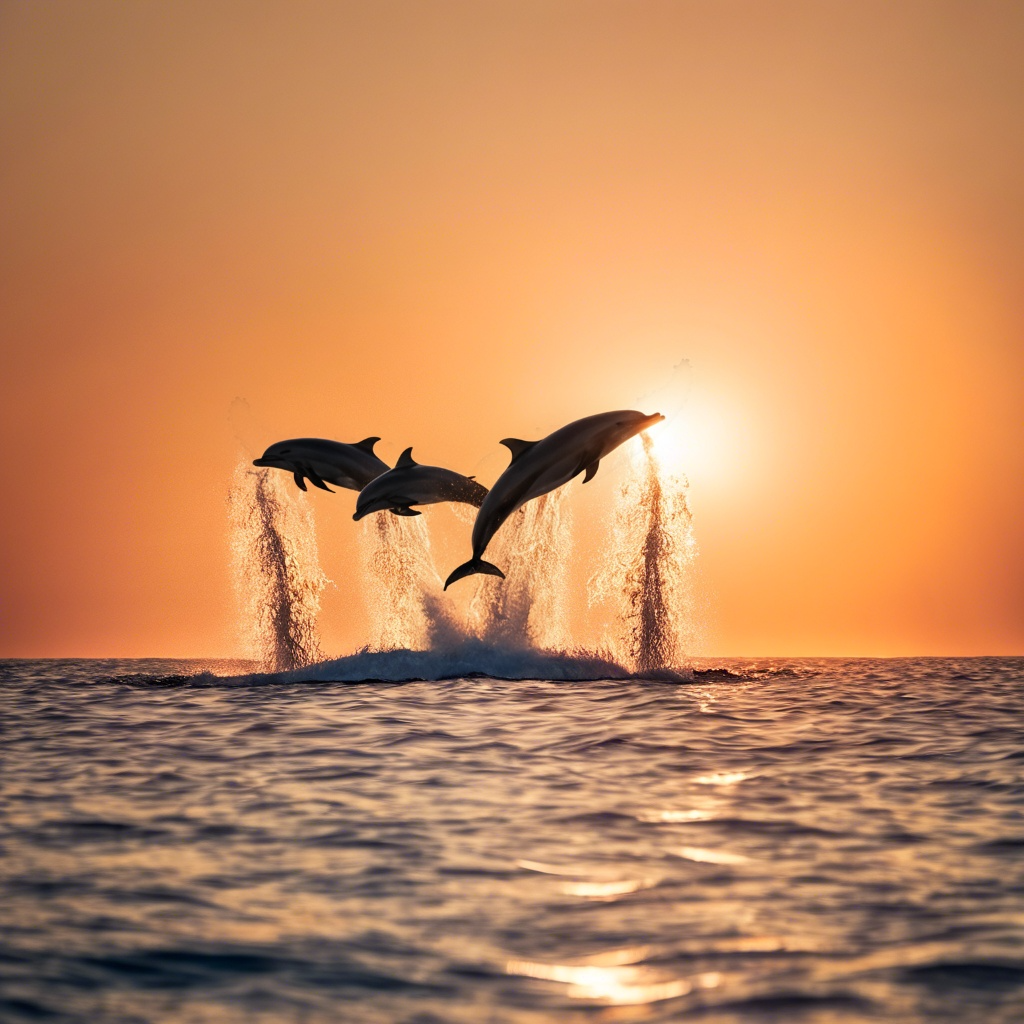

The results of `editing` task by the Stable Diffusion model is very impressive. The `whale` is entirely replaced by `dolphins` in the resulting image without any noticeable noise or degragradation in the quality of the picture. Only the whale got replaced with a pod of dolphins as instructed in the prompt without any changes in other parts of the image like the ocean and the background sunset remains as is. The whale got replaced as if it never existed before which is quite amazing. However we notice the water splash caused by the whale's tail from previous image is still remianing in the modified image because the input prompt didn't mention to remove the water splash.

One important thing to notice in the modified image is that this time the `whole body of the dolphins is out of water` unlike `only the tail` in case of whale in previous image. This is mostly because it is quite natural for dolphins to jump entirely out of water and hence it is highly prabable that the model has seen more of such images during training. 